In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import dataprob
import pandas as pd
import numpy as np

### Example model and data

Models should have the form:
```
def some_model(param1,param2,param3,...other_args,...other_kwargs):
    return observable
```

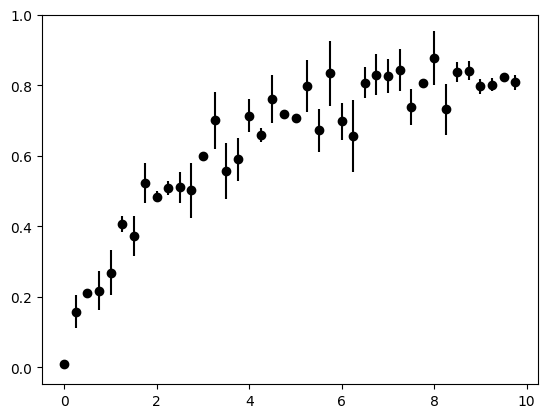

,X,Y,Y_stdev,residual,weighted_residual
0,0.00,0.010697,0.010697,0.010697,1.0
1,0.25,0.158333,0.047222,0.047222,1.0
2,0.50,0.209849,0.009849,0.009849,1.0
3,0.75,0.217865,0.054863,-0.054863,-1.0
4,1.00,0.268995,0.064339,-0.064339,-1.0


In [2]:
def binding_model(K,X=None):
    """
    Simple, saturating binding curve.

    K: association constant
    X: vector of X concentrations
    """

    return K*X/(1 + K*X)

df = pd.read_csv("binding-curves_noise-0.050.csv",index_col=0)

fig, ax = plt.subplots()
ax.errorbar(df.X,df.Y,yerr=df.Y_stdev,fmt="o",color="black")
plt.show()

df.head()

### Wrap the binding model

In [3]:
mw = dataprob.ModelWrapper(binding_model)
print(mw.fit_parameters)
print(mw.other_arguments)

{'K': <dataprob.fit_param.FitParameter object at 0x112b9fef0>}
{'X': None}


In [4]:
mw.X = df.X
mw.K = 22
mw.K.bounds = [-20,20]
mw.K.name = "equilibrium constant"

/Users/harmsm/miniconda3/lib/python3.12/site-packages/dataprob/fit_param.py:306: UserWarning: The previous guess (22.0) is outside the new
bounds ([-20.  20.]). The guess has been updated to
'20.0'.

  warnings.warn(w,UserWarning)


### Construct the fitter and do the fit

In [6]:
f = dataprob.MLFitter()
f.model = mw
#lm.K.guess = 22
#lm.K.fixed = False
f.fit(y_obs=df.Y)
f.fit_df

,param,estimate,stdev,low_95,high_95,guess,prior_mean,prior_std,lower_bound,upper_bound,fixed
0,equilibrium constant,0.493423,0.280837,-0.075103,1.061949,20.0,NaN,NaN,-20.0,20.0,False


In [8]:
f = dataprob.MLFitter()
f.fit(model=mw.model,guesses=[1.0],y_obs=df.Y,)
print(f.success)
print(f.estimate)
f.fit_df

True
[0.49342315]


,param,estimate,stdev,low_95,high_95,guess,prior_mean,prior_std,lower_bound,upper_bound,fixed
0,equilibrium constant,0.493423,0.280837,-0.075103,1.061949,1.0,NaN,NaN,-20.0,20.0,False


### Alternate way to construct fitter and do fit

In [9]:
f = dataprob.MLFitter()
f.model = mw.model
f.guesses = [1]
f.y_obs = df.Y
f.fit()
print(f.success)
print(f.estimate)
f.fit_df

True
[0.49342315]


,param,estimate,stdev,low_95,high_95,guess,prior_mean,prior_std,lower_bound,upper_bound,fixed
0,equilibrium constant,0.493423,0.280837,-0.075103,1.061949,1.0,NaN,NaN,-20.0,20.0,False


### Add weighted residuals

In [11]:
f = dataprob.MLFitter()
f.fit(model=mw.model,y_obs=df.Y,y_stdev=df.Y_stdev)
print(f.success)
print(f.estimate)
f.fit_df

True
[0.49837013]


,param,estimate,stdev,low_95,high_95,guess,prior_mean,prior_std,lower_bound,upper_bound,fixed
0,equilibrium constant,0.49837,0.000851,0.496646,0.500094,1.0,NaN,NaN,-20.0,20.0,False


### Plotting

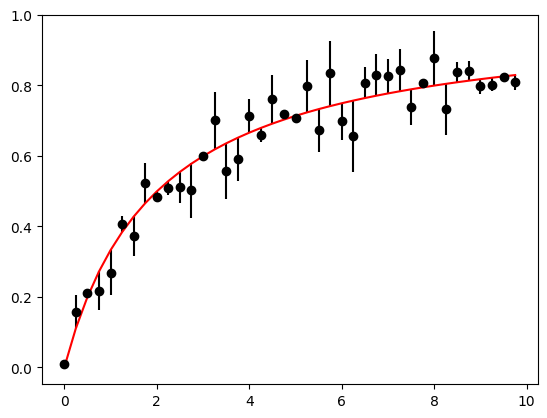

In [12]:
# Plot the fit
fig, ax = plt.subplots()
ax.errorbar(df.X,df.Y,yerr=df.Y_stdev,fmt="o",color="black")
#ax.plot(df.X,mw.model(),"-",color='red')
ax.plot(df.X,mw.model(f.estimate),"-",color='red')

### Corner plot

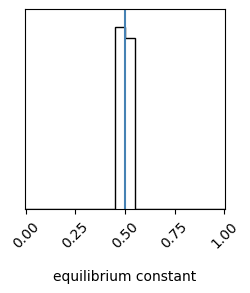

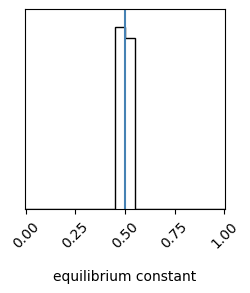

In [13]:
f.corner_plot()

### You can add parameter bounds and names

In [14]:
mw.bounds

array([[-20.],
       [ 20.]])

In [16]:
f = dataprob.MLFitter()
f.model = mw.model
f.guesses = [1.0]
f.y_obs = df.Y
f.y_stdev = df.Y_stdev
f.bounds = [[0],[np.inf]]
f.param_names = ["Kx"]
f.fit()
print(f.success)
print(f.estimate)
f.fit_df

True
[0.49837013]


,param,estimate,stdev,low_95,high_95,guess,prior_mean,prior_std,lower_bound,upper_bound,fixed
0,equilibrium constant,0.49837,0.000851,0.496646,0.500094,1.0,NaN,NaN,0.0,inf,False


### Bayesian fitter

In [18]:
f = dataprob.BayesianFitter()
f.fit(model=mw.model,guesses=[1.0],y_obs=df.Y,y_stdev=df.Y_stdev)
print(f.success)
print(f.estimate)
f.fit_df


100%|█████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.67it/s]

True
[0.49840315]


,param,estimate,stdev,low_95,high_95,guess,prior_mean,prior_std,lower_bound,upper_bound,fixed
0,equilibrium constant,0.498403,0.001196,0.495971,0.500783,1.0,NaN,NaN,0.0,inf,False


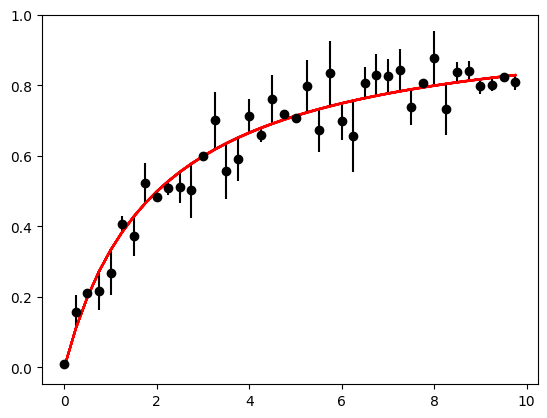

In [19]:
fig, ax = plt.subplots()
ax.errorbar(df.X,df.Y,yerr=df.Y_stdev,fmt="o",color="black")

# Plot 100 fits sampled from posterior
for i in range(0,len(f.samples),90):
    ax.plot(df.X,mw.model(f.samples[i,:]),"-",color='red',alpha=0.1)